In [1]:
%cd ..

/Users/ani/Documents/time-series-forecasting


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from statsmodels.tsa.stattools import adfuller,pacf,acf
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
df_train = pd.read_csv('./data/train.csv', low_memory=False)
df_test = pd.read_csv('./data/test.csv', low_memory=False)

# Transform Date column into datetime format
df_train['ds'] = pd.to_datetime(df_train['Date'])
df_test['ds'] = pd.to_datetime(df_test['Date'])

In [4]:
df_train.rename(columns={'number_sold':'y'}, inplace=True)
df_test.rename(columns={'number_sold':'y'}, inplace=True)

In [5]:
df_train['ID'] = df_train['store'].astype('str') + '_' + df_train['product'].astype('str')

In [6]:
df = df_train.drop_duplicates(subset=['ID', 'ds'])

In [7]:
df['ds'] = df['ds'].dt.date

In [49]:
from neuralprophet import NeuralProphet

# Create model
model = NeuralProphet(
    trend_global_local = 'local',
    season_global_local= 'local',
    daily_seasonality=False,
    n_lags= 375,
    n_forecasts=365,
    epochs=20
)


In [50]:
df['ds'] = pd.to_datetime(df['ds'])
df['ds'] = df['ds'].dt.date

In [51]:
df[['ID', 'ds', 'y']].dtypes

ID    object
ds    object
y      int64
dtype: object

In [52]:
# Fit model
metrics = model.fit(df[['ID', 'ds', 'y']], freq='D')

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/basic/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.97% of the data.
WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/basic/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/basic/lib/python3.12/site-packages/neuralprophet/df_utils.

Epoch 20: 100%|██████████| 20/20 [00:09<00:00,  2.07it/s, loss=0.0109, v_num=3, MAE=0.0685, RMSE=0.0919, Loss=0.011, RegLoss=0.000]    


In [59]:
metrics

,MAE,RMSE,Loss,RegLoss,epoch
0,0.178998,0.231174,0.065496,0.0,0
1,0.113146,0.150490,0.028437,0.0,1
2,0.092831,0.124318,0.019776,0.0,2
3,0.077609,0.103821,0.013937,0.0,3
4,0.072263,0.096610,0.012089,0.0,4
5,0.071395,0.095473,0.011811,0.0,5
6,0.071014,0.095034,0.011704,0.0,6
7,0.070509,0.094442,0.011559,0.0,7
8,0.070047,0.093871,0.011422,0.0,8
9,0.069767,0.093527,0.011339,0.0,9


In [ ]:
df_pred = model.predict(model.make_future_dataframe(df_train[['ds', 'ID', 'y']]))

In [54]:
cols = [x for x in df_pred.columns if 'hat' in x]
df_pred['y_pred'] = df_pred[df_pred['ds'].dt.year>2018][cols].sum(axis=1)

In [55]:
df_test['ID'] = df_test['store'].astype('str') + '_' + df_test['product'].astype('str')

In [57]:
df_comb = df_pred.merge(
    df_test, 
    on=['ds', 'ID'], 
    suffixes=['_preds', '_actual'])

In [58]:
mean_absolute_percentage_error(df_comb['y_pred'], df_comb['y_actual'])

0.01624615676701069

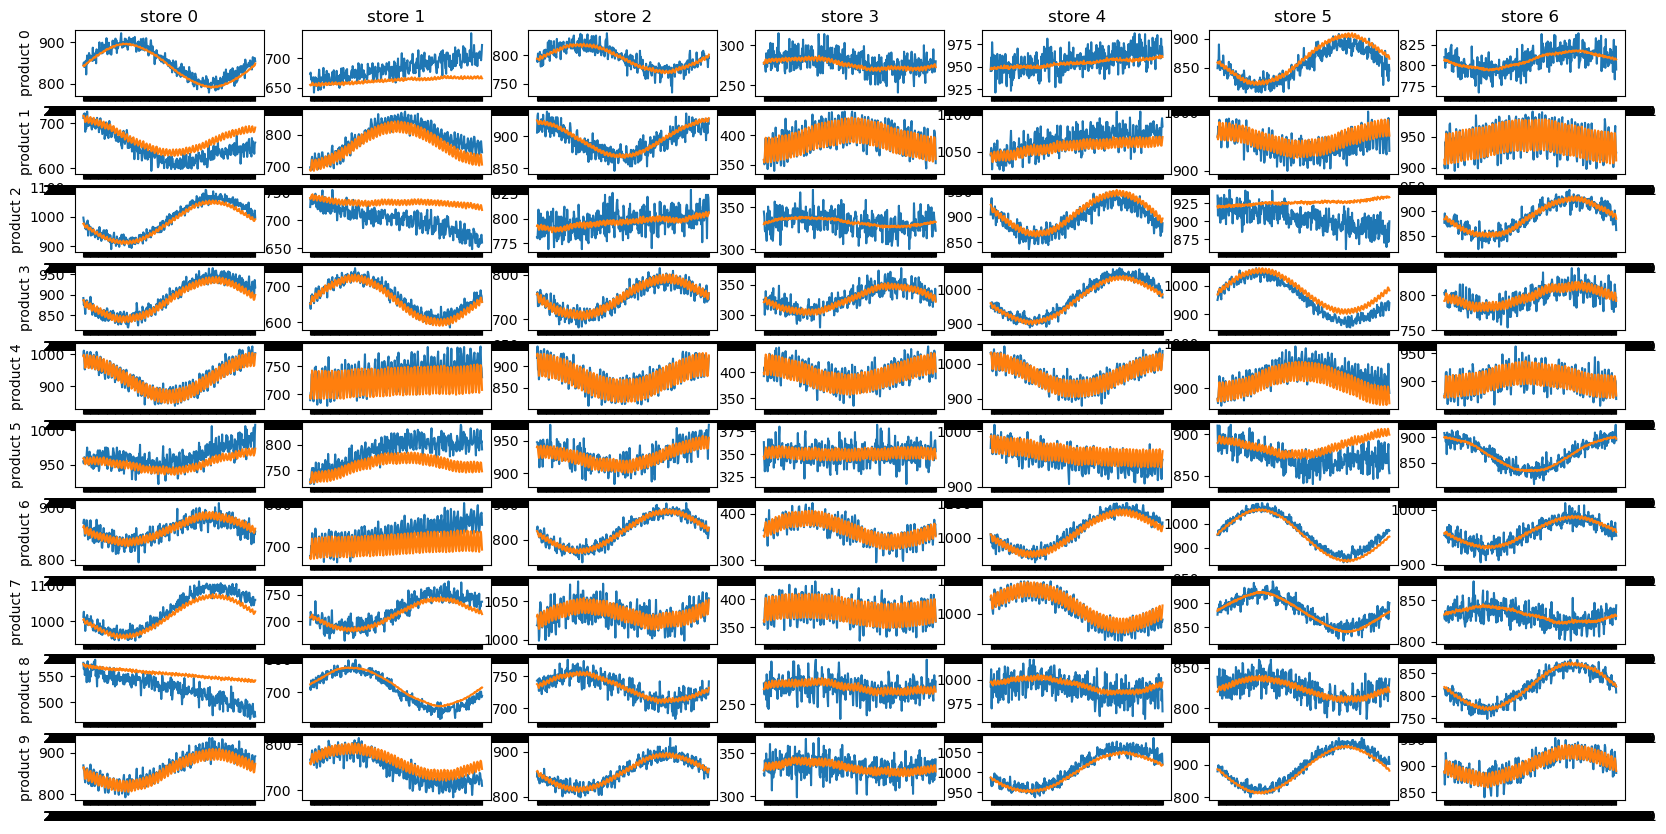

In [69]:
fig, ax = plt.subplots(10,7, figsize=(20, 10))

for s in range(7):
    for p in range(10):
        sns.lineplot(x='Date', y='y_actual', data=df_comb[df_comb['ID'] == f'{s}_{p}'], ax= ax[p, s])
        sns.lineplot(x='Date', y='y_pred', data=df_comb[df_comb['ID'] == f'{s}_{p}'], ax= ax[p, s])
        ax[p, s].set_xlabel('')
        ax[p, s].set_ylabel('')
    ax[0, s].set_title(f'store {s}')
for p in range(10):
    ax[p, 0].set_ylabel(f'product {p}')